In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# from collections import defaultdict

path = '/Users/marc/ds/metis/metisgh/hockey/'

tables = {}
for filename in glob.glob(os.path.join(path, '*.csv')):
    table = filename.replace(path,'')
    table = table.replace('.csv','')
#     print(table,filename)

%matplotlib inline

/Users/marc/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Import Relevant Tables

In [35]:
# abbrev = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/abbrev.csv')
# AwardsCoaches = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/AwardsCoaches.csv')
# AwardsMisc = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/AwardsMisc.csv')
AwardsPlayers = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/AwardsPlayers.csv')
# Coaches = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Coaches.csv')
# Coaches_beta = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Coaches_beta.csv')
# CombinedShutouts = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/CombinedShutouts.csv')
# Goalies = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Goalies.csv')
# GoaliesSC = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/GoaliesSC.csv')
# GoaliesShootout = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/GoaliesShootout.csv')
HOF = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF.csv')
Master = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Master.csv')
Scoring = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Scoring.csv')
# ScoringSC = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/ScoringSC.csv')
# ScoringShootout = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/ScoringShootout.csv')
# ScoringSup = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/ScoringSup.csv')
SeriesPost = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/SeriesPost.csv')
Teams = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/Teams.csv')
# TeamsHalf = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/TeamsHalf.csv')
# TeamSplits = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/TeamSplits.csv')
# TeamsPost = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/TeamsPost.csv')
TeamsSC = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/TeamsSC.csv')
# TeamVsTeam = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/TeamVsTeam.csv')

In [36]:
Scoring.year.min()

1909

In [37]:
# Add playerID to HOF table
HOF['playerID'] = [x[:-1] for x in HOF['hofID']]
HOF = HOF[HOF.category=='Player']

### Hall of Fame Inductees by Year

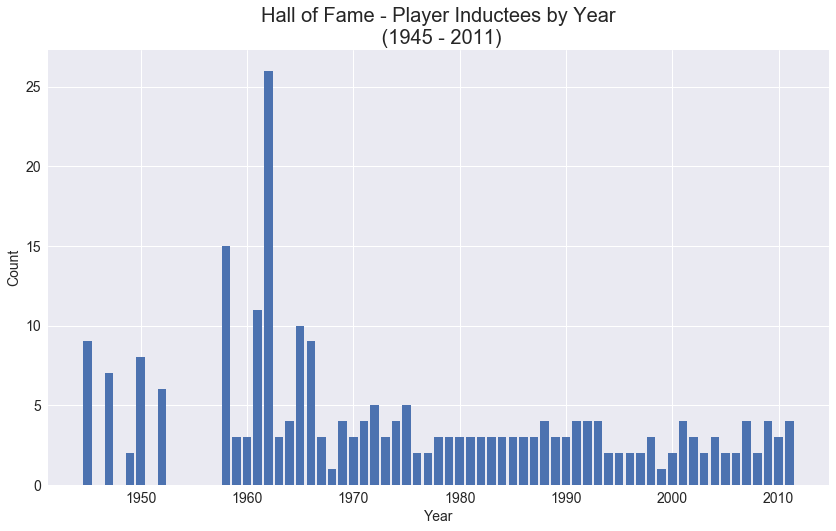

In [38]:
by_year = HOF.groupby('year')['name'].count().reset_index().sort_values('year')
plt.figure(figsize=(14,8))
plt.title('Hall of Fame - Player Inductees by Year\n (1945 - 2011)',fontsize=20)
plt.xlabel('Year',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.bar(by_year.year,by_year.name);

### Add HOF column to Scoring Table

In [39]:
Scoring['HOF'] = [1 if x == True else 0 for x in Scoring.playerID.isin(HOF.playerID)]

### Fix Plus/Minus column name

In [40]:
Scoring.columns = ['playerID', 'year', 'stint', 'tmID', 'lgID', 'pos', 'GP', 'G', 'A',
       'Pts', 'PIM', 'plus_min', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG', 'SOG',
       'PostGP', 'PostG', 'PostA', 'PostPts', 'PostPIM', 'Postplus_min', 'PostPPG',
       'PostPPA', 'PostSHG', 'PostSHA', 'PostGWG', 'PostSOG', 'HOF']

### Calculate Playoff Wins column; add to Scoring Table

In [41]:
serieswins = SeriesPost[['year','round','tmIDWinner']] # series wins by team/year
serieswins = serieswins.groupby(['year','tmIDWinner'])['round'].count().reset_index()
serieswins.columns = ['year','tmID','series_wins']

In [42]:
Scoring = pd.merge(Scoring,serieswins,how='outer')
Scoring.series_wins =  Scoring.series_wins.fillna(0)

### Add Team Rank and Stanley Cup winners to Scoring Table

In [43]:
teamrank = Teams[['tmID','year','rank']]

stanley = Teams[['tmID','year','playoff']]
stanley = stanley[stanley.playoff == 'SC']
stanley['playoff'] = 1
stanley.columns = ['tmID', 'year', 'won_cup']

Scoring = pd.merge(Scoring,teamrank,how='outer')
Scoring = pd.merge(Scoring,stanley,how='outer')

Scoring.won_cup = Scoring.won_cup.fillna(0)

### Team Percentile Rank by Year

In [44]:
ranks = Teams.groupby(['year','lgID'])['rank'].max().reset_index()
ranks.columns = ['year','lgID','numteams']
Scoring = pd.merge(Scoring,ranks,how='outer')
Scoring['team_pct'] = 1-(Scoring['rank']/Scoring.numteams)

### Player vs. League - Performance Percentiles by Year

In [45]:
Scoring['G_rank'] = Scoring.groupby(['year']).G.rank(pct=True)
Scoring['A_rank'] = Scoring.groupby(['year']).A.rank(pct=True)
Scoring['Pts_rank'] = Scoring.groupby(['year']).Pts.rank(pct=True)
Scoring['Plusmin_rank'] = Scoring.groupby(['year']).plus_min.rank(pct=True)
Scoring['SOG_rank'] = Scoring.groupby(['year']).SOG.rank(pct=True)

### Player vs. Team - Performance Percentiles by Year

In [46]:
Scoring['G_rank_T'] = Scoring.groupby(['year','tmID']).G.rank(pct=True)
Scoring['A_rank_T'] = Scoring.groupby(['year','tmID']).A.rank(pct=True)
Scoring['Pts_rank_T'] = Scoring.groupby(['year','tmID']).Pts.rank(pct=True)
Scoring['Plusmin_rank_T'] = Scoring.groupby(['year','tmID']).plus_min.rank(pct=True)
Scoring['SOG_rank_T'] = Scoring.groupby(['year','tmID']).SOG.rank(pct=True)
Scoring[Scoring.G_rank_T==1];

### Add first & last year to Scoring Table

In [47]:
LastYear = pd.DataFrame(Scoring.groupby('playerID')['year'].max().reset_index())
LastYear.columns = ['playerID','LastYear'] 
Scoring = pd.merge(Scoring,LastYear,how='outer')

FirstYear = pd.DataFrame(Scoring.groupby('playerID')['year'].min().reset_index())
FirstYear.columns = ['playerID','FirstYear'] 
Scoring = pd.merge(Scoring,FirstYear,how='outer')

### Show count of null values by column

In [48]:
Scoring.isnull().sum().sort_values(ascending=False);

### Drop Postseason Statistics

In [49]:
subset = [col for col in Scoring.columns if 'Post' in col]
Scoring.drop(subset,axis=1,inplace=True)
Scoring.columns

Index(['playerID', 'year', 'stint', 'tmID', 'lgID', 'pos', 'GP', 'G', 'A',
       'Pts', 'PIM', 'plus_min', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG',
       'SOG', 'HOF', 'series_wins', 'rank', 'won_cup', 'numteams', 'team_pct',
       'G_rank', 'A_rank', 'Pts_rank', 'Plusmin_rank', 'SOG_rank', 'G_rank_T',
       'A_rank_T', 'Pts_rank_T', 'Plusmin_rank_T', 'SOG_rank_T', 'LastYear',
       'FirstYear'],
      dtype='object')

### Check nulls again

In [50]:
Scoring.isnull().sum().sort_values(ascending=False).head(10);

### Fill PPA, SHA, and GTG nulls with zeros

In [51]:
Scoring.series_wins = Scoring.series_wins.fillna(0)
Scoring.PPA = Scoring.PPA.fillna(0)
Scoring.SHA = Scoring.SHA.fillna(0)
Scoring.GTG = Scoring.GTG.fillna(0)

### Check nulls again

In [52]:
Scoring.isnull().sum().sort_values(ascending=False);

### Drop NaNs from Pts, PIM, A, G, GP and pos

In [53]:
subset=['Pts','PIM','A','G','GP','pos','G_rank_T','A_rank_T','Pts_rank_T','G_rank','A_rank','Pts_rank']
Scoring.dropna(axis=0,subset=subset,inplace=True)
Scoring.isnull().sum().sort_values(ascending=False);

### Linear Regressions to fill in NaNs

In [54]:
# Scoring.corr().reset_index();
# 'plus_min','SOG','GWG','SHG','PPG'
# 'GP', 'G', 'A','Pts','PIM', 'PPA','SHA','GTG','SOG','HOF','LastYear'

In [55]:
# y, X = patsy.dmatrices(''' SOG ~ 213.39 +
# GP + G + A + Pts + PPA + SHA + GTG + HOF + LastYear + team_pct + series_wins + won_cup + rank
# ''', data=Scoring, return_type="dataframe")

# # Create model
# model = sm.OLS(y, X)
# # Fit model to training set
# fit = model.fit()
# # Print summary statistics of the model's performance
# fit.summary()
# pred_X = Scoring[['SOG','GP','Pts','G','A','Pts','PPA','SHA','GTG','HOF',
#                  'LastYear','team_pct','series_wins','won_cup','rank']]
# pred_X = pred_X[pred_X.SOG.isnull()]
# nan_X = pred_X.iloc[:,1:]
# # new_X = 
# fit.predict(nan_X)

# # pred_X['SOG'] = new_X
# # pred_X

In [56]:
Scoring.groupby('HOF')['series_wins'].mean()

HOF
0    0.524091
1    0.768335
Name: series_wins, dtype: float64

In [57]:
Scoring.groupby('HOF')['team_pct'].mean()

HOF
0    0.411137
1    0.500912
Name: team_pct, dtype: float64

### Make positions uniform; only keep main position

In [58]:
Scoring['pos'] = [x[0] for x in Scoring.pos]
Scoring.pos.unique()

array(['C', 'L', 'G', 'R', 'D', 'W', 'F'], dtype=object)

In [59]:
Scoring.pos.replace('C','F',True)
Scoring.pos.replace('R','F',True)
Scoring.pos.replace('L','F',True)
Scoring.pos.replace('W','F',True)
Scoring.groupby(['playerID'])['pos'].nunique().reset_index().sort_values('pos',ascending=False);

In [60]:
true_pos = Scoring.groupby(['playerID'])['pos'].agg(lambda x:x.value_counts().index[0]).reset_index()
true_pos.columns = ['playerID','true_pos']

In [61]:
Scoring = pd.merge(Scoring,true_pos,how='outer')

### Group by playerID - sum/average

In [62]:
summed = Scoring.groupby('playerID')[
        'GP', 'G', 'A','Pts', 'PIM', 'plus_min', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG',
       'SOG','series_wins','won_cup'].sum().reset_index()

averaged = Scoring.groupby('playerID')[
        'team_pct','G_rank', 'A_rank', 'Pts_rank', 'Plusmin_rank', 'SOG_rank', 'G_rank_T',
       'A_rank_T', 'Pts_rank_T', 'Plusmin_rank_T', 'SOG_rank_T'].mean().reset_index()

rest = Scoring[['playerID','true_pos','HOF','FirstYear','LastYear']]

summary = pd.merge(summed,averaged,how='outer')

In [63]:
summary = pd.merge(summary,rest.drop_duplicates(),how='outer')
summary.shape

(7333, 31)

### Create 'awards count' column

In [64]:
awards_count = AwardsPlayers.groupby('playerID')['award'].count().reset_index()
summary = pd.merge(summary,awards_count,how='outer')
summary.rename(index=str, columns={'award': 'award_count'},inplace=True)
summary.award_count.fillna(0,inplace=True)

## Master table -- clean up

In [65]:
Master.columns

Index(['playerID', 'coachID', 'hofID', 'firstName', 'lastName', 'nameNote',
       'nameGiven', 'nameNick', 'height', 'weight', 'shootCatch', 'legendsID',
       'ihdbID', 'hrefID', 'firstNHL', 'lastNHL', 'firstWHA', 'lastWHA', 'pos',
       'birthYear', 'birthMon', 'birthDay', 'birthCountry', 'birthState',
       'birthCity', 'deathYear', 'deathMon', 'deathDay', 'deathCountry',
       'deathState', 'deathCity'],
      dtype='object')

In [66]:
Master = Master[['playerID', 'firstName', 'lastName','height', 'weight', 'shootCatch', 
                 'firstNHL', 'lastNHL', 'firstWHA', 'lastWHA',
                'birthCountry','birthState','birthCity','birthYear']]
Master.shootCatch.value_counts()

L    4604
R    2443
B       1
Name: shootCatch, dtype: int64

In [67]:
Master.shootCatch.replace('B','L',True)

In [68]:
Master.shootCatch.value_counts()

L    4605
R    2443
Name: shootCatch, dtype: int64

In [69]:
Master['NHL_Years'] = Master.lastNHL - Master.firstNHL
Master.NHL_Years = Master.NHL_Years.fillna(0)
Master['WHA_Years'] = Master.lastWHA - Master.firstWHA
Master.WHA_Years = Master.WHA_Years.fillna(0)
Master['Career_Years'] = Master.NHL_Years + Master.WHA_Years + 1

In [70]:
summary = pd.merge(summary,Master,how='inner')

In [71]:
summary[summary.Career_Years==0].HOF.value_counts() # 14 HOF'ers have no career stats!

Series([], Name: HOF, dtype: int64)

In [72]:
summary.HOF.value_counts()

0    7121
1     212
Name: HOF, dtype: int64

In [73]:
summary['name'] = summary.firstName + ' ' + summary.lastName

In [74]:
# Hall of Fame by Country
hof_country = summary.groupby(['birthCountry'],as_index=False)['HOF'].sum()
all_country = summary.groupby(['birthCountry'],as_index=False)['playerID'].count()

country = pd.concat([hof_country,all_country.playerID],axis=1)
country.columns = ['birthCountry','HOF_ct','player_ct']
country = country[['birthCountry','player_ct','HOF_ct']]
country['country_pct'] = country['HOF_ct']/country['player_ct']
country_chance = country[['birthCountry','country_pct']]
country_chance
summary = pd.merge(summary,country_chance,how='outer')

In [75]:
summary.columns

Index(['playerID', 'GP', 'G', 'A', 'Pts', 'PIM', 'plus_min', 'PPG', 'PPA',
       'SHG', 'SHA', 'GWG', 'GTG', 'SOG', 'series_wins', 'won_cup', 'team_pct',
       'G_rank', 'A_rank', 'Pts_rank', 'Plusmin_rank', 'SOG_rank', 'G_rank_T',
       'A_rank_T', 'Pts_rank_T', 'Plusmin_rank_T', 'SOG_rank_T', 'true_pos',
       'HOF', 'FirstYear', 'LastYear', 'award_count', 'firstName', 'lastName',
       'height', 'weight', 'shootCatch', 'firstNHL', 'lastNHL', 'firstWHA',
       'lastWHA', 'birthCountry', 'birthState', 'birthCity', 'birthYear',
       'NHL_Years', 'WHA_Years', 'Career_Years', 'name', 'country_pct'],
      dtype='object')

In [76]:
summary['logGP'] = np.log(summary.GP)
summary['logCareer_Years'] = np.log(summary.Career_Years)
summary.award_count.fillna(0,inplace=True)

# create Height/Weight combined indicator
# summary['presence'] = summary.

In [77]:
# reorder & filter columns
summary = summary[[
        'playerID','name','true_pos','shootCatch',
        'birthCountry', 'birthState', 'birthCity', 'birthYear',
        'GP','G','A','Pts','PIM','plus_min','PPG','PPA','SHG','SHA','GWG', 'GTG', 'SOG', 
        'logGP','logCareer_Years',
        'award_count','series_wins', 'won_cup', 'team_pct', 'country_pct',
        'G_rank','A_rank', 'Pts_rank', 'Plusmin_rank', 'SOG_rank', 
        'G_rank_T','A_rank_T','Pts_rank_T', 'Plusmin_rank_T', 'SOG_rank_T', 
        'height', 'weight', 
        'FirstYear', 'LastYear','Career_Years',
        'HOF']]

## Remove goalies!

In [78]:
summary = summary[summary.true_pos!='G'].reset_index()

In [79]:
summary[summary.plus_min.isnull()]; #1389 players with no plus/minus

### Binarize F/D --> Forward = 1, Defense = 0

In [80]:
summary.true_pos.replace('F',1,True)
summary.true_pos.replace('D',0,True)

In [81]:
len(summary[summary.Career_Years==0])
# 1504 players with no NHL or WHA data!

0

In [82]:
HOF_split = summary.HOF.value_counts()
HOF_split[1]/HOF_split[0] # class ratio HOF/not_HOF

0.028464185173600252

In [83]:
hockey = summary.copy()

In [84]:
### 2013-2014 Players (for Eligibility)
Recent = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/NHLPlayers2013-14.csv')
allrecent = hockey[hockey.name.isin(Recent.Names)]
allrecent = allrecent[['playerID']]
allrecent['recent'] = 1
hockey = pd.merge(hockey,allrecent,how='outer')
hockey.recent.fillna(0,inplace=True)

### New HOF inductees since 2011 -- Holdout 
HOF2 = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF2.csv')
HOF2 = HOF2[HOF2.Year > 2011] ## Rogie Vachon & Dominik Hasek = Goalies
HOF2_names = HOF2.Name
new_HOF = hockey[hockey.name.isin(HOF2_names)].copy()
new_HOF['new_HOF'] = 1

hockey = pd.merge(hockey,new_HOF,how='outer')
hockey.new_HOF.fillna(0,inplace=True)

## HOF-Eligible Players
HOFtable = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF.csv')
HOFtable['playerID'] = [x[:-1] for x in HOFtable['hofID']]
HOFtable = HOFtable[HOFtable.category=='Player']
HOFtable = HOFtable[['playerID','year']]
HOFtable.columns = ['playerID','HOFyear']
HOFdelay = pd.merge(hockey[hockey.HOF==1],HOFtable,how='inner')

In [85]:
hockey.drop('index',inplace=True,axis=1)
hockey2 = summary.dropna(axis=0).copy()

In [86]:
hockey.to_pickle('/Users/marc/ds/metis/metisgh/hockey.csv')
hockey2.to_pickle('/Users/marc/ds/metis/metisgh/hockey_filtered.csv')

### Visualizations --> Fix references to Summary

In [87]:
hockey.corr()

,true_pos,birthYear,GP,G,A,Pts,PIM,plus_min,PPG,PPA,...,Plusmin_rank_T,SOG_rank_T,height,weight,FirstYear,LastYear,Career_Years,HOF,recent,new_HOF
true_pos,1.000000,-0.029772,-0.009115,0.220823,0.056970,0.125285,-0.088498,-0.045116,0.155020,-0.010693,...,-0.052727,0.123291,-0.227964,-0.251087,-0.030124,-0.032943,-0.016712,0.012421,-0.007510,-0.000238
birthYear,-0.029772,1.000000,0.039458,-0.028054,0.021550,0.001808,0.049301,-0.013209,-0.091141,0.182632,...,0.011891,-0.093577,0.487329,0.565027,0.994380,0.981198,0.007225,-0.229915,0.375659,0.023982
GP,-0.009115,0.039458,1.000000,0.795393,0.873115,0.862555,0.743478,0.242217,0.706018,0.562897,...,0.027245,0.743515,0.084402,0.177938,0.012996,0.198469,0.911501,0.268524,0.044776,0.166179
G,0.220823,-0.028054,0.795393,1.000000,0.902352,0.964138,0.483552,0.310170,0.932798,0.580146,...,0.075803,0.680628,-0.033361,0.028282,-0.051842,0.092084,0.697042,0.391323,0.023294,0.207078
A,0.056970,0.021550,0.873115,0.902352,1.000000,0.984380,0.557990,0.391015,0.868599,0.704313,...,0.108452,0.689383,0.013693,0.079991,-0.002616,0.152093,0.763137,0.369534,0.034385,0.242585
Pts,0.125285,0.001808,0.862555,0.964138,0.984380,1.000000,0.541124,0.367283,0.914758,0.670684,...,0.097716,0.701873,-0.005198,0.060811,-0.022788,0.131271,0.754658,0.387402,0.030689,0.233968
PIM,-0.088498,0.049301,0.743478,0.483552,0.557990,0.541124,1.000000,0.128904,0.414792,0.334313,...,-0.015828,0.445238,0.158930,0.271717,0.027187,0.168774,0.694552,0.161778,-0.012191,0.111544
plus_min,-0.045116,-0.013209,0.242217,0.310170,0.391015,0.367283,0.128904,1.000000,0.292705,0.241395,...,0.426802,0.132935,0.018991,0.025546,-0.021394,0.050087,0.190791,0.389698,0.044627,0.135756
PPG,0.155020,-0.091141,0.706018,0.932798,0.868599,0.914758,0.414792,0.292705,1.000000,0.714591,...,0.079415,0.627472,-0.042613,0.040157,-0.135896,0.088288,0.610407,0.407031,0.029749,0.267418
PPA,-0.010693,0.182632,0.562897,0.580146,0.704313,0.670684,0.334313,0.241395,0.714591,1.000000,...,0.089375,0.483370,0.090502,0.174680,0.165856,0.261210,0.474155,0.111544,0.143686,0.374736


In [100]:
hockey.head()

,playerID,name,true_pos,shootCatch,birthCountry,birthState,birthCity,birthYear,GP,G,...,Plusmin_rank_T,SOG_rank_T,height,weight,FirstYear,LastYear,Career_Years,HOF,recent,new_HOF
0,aaltoan01,Antti Aalto,1,L,Finland,NaN,Lappeenranta,1975.0,151.0,11.0,...,0.481973,0.383366,73.0,210.0,1997,2000,4.0,0,0.0,0.0
1,aholape01,Peter Ahola,0,L,Finland,NaN,Espoo,1968.0,123.0,10.0,...,0.550983,0.342509,75.0,205.0,1991,1993,3.0,0,0.0,0.0
2,alatami01,Mika Alatalo,1,L,Finland,NaN,Oulu,1971.0,152.0,17.0,...,0.435829,0.648173,72.0,202.0,1999,2000,2.0,0,0.0,0.0
3,bergak01,Aki Berg,0,L,Finland,NaN,Turku,1977.0,606.0,15.0,...,0.402757,0.532301,75.0,213.0,1995,2005,11.0,0,0.0,0.0
4,bergese01,Sean Bergenheim,1,L,Finland,NaN,Helsinki,1984.0,388.0,71.0,...,0.444182,0.778885,70.0,194.0,2003,2011,9.0,0,1.0,0.0


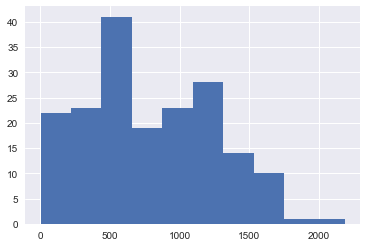

In [88]:
# Hall of Fame by Career Length in Games Played
HOF_gp = hockey[hockey.HOF==1].GP.sort_values(ascending=False)
HOF_gp.hist()

In [89]:
def plot_distribution( df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df , hue=target, aspect=3, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(df[var].min() , df[var].max()))
    facet.add_legend()

In [90]:
hockey.columns

Index(['playerID', 'name', 'true_pos', 'shootCatch', 'birthCountry',
       'birthState', 'birthCity', 'birthYear', 'GP', 'G', 'A', 'Pts', 'PIM',
       'plus_min', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG', 'SOG', 'logGP',
       'logCareer_Years', 'award_count', 'series_wins', 'won_cup', 'team_pct',
       'country_pct', 'G_rank', 'A_rank', 'Pts_rank', 'Plusmin_rank',
       'SOG_rank', 'G_rank_T', 'A_rank_T', 'Pts_rank_T', 'Plusmin_rank_T',
       'SOG_rank_T', 'height', 'weight', 'FirstYear', 'LastYear',
       'Career_Years', 'HOF', 'recent', 'new_HOF'],
      dtype='object')

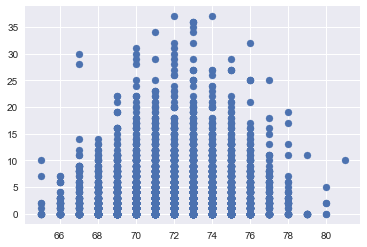

In [108]:
plt.scatter(hockey.height,hockey.series_wins)

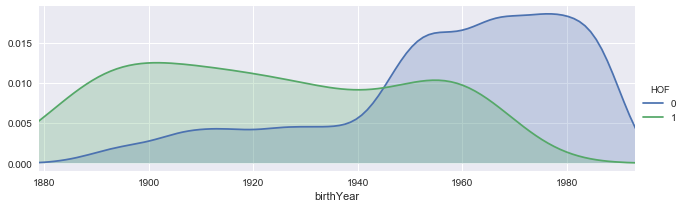

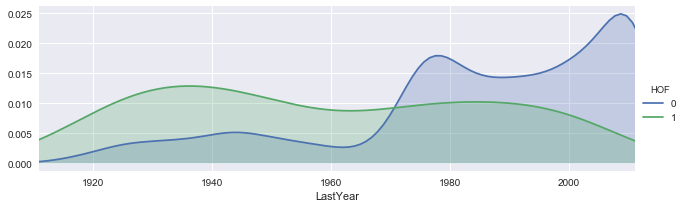

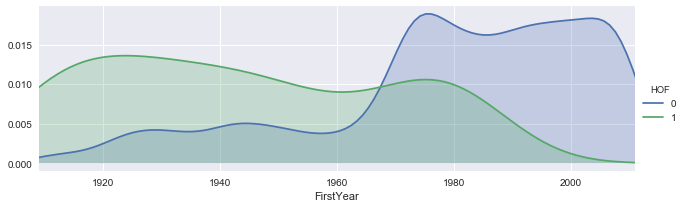

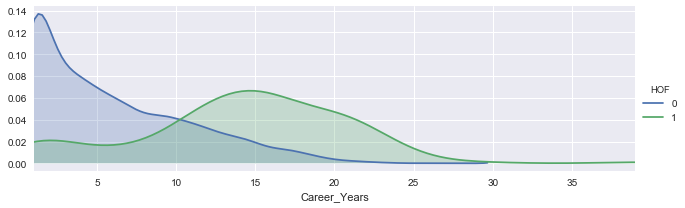

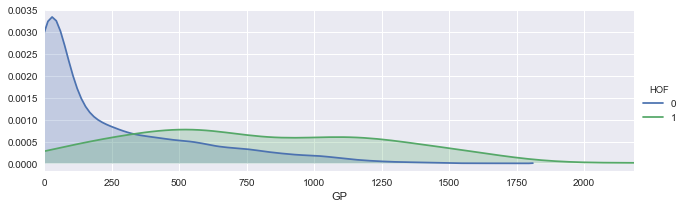

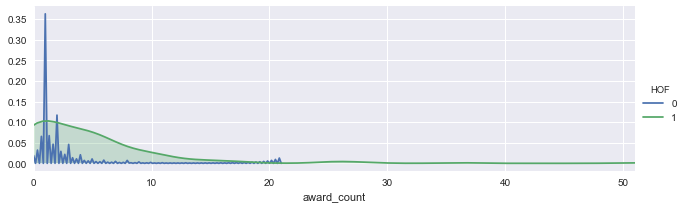

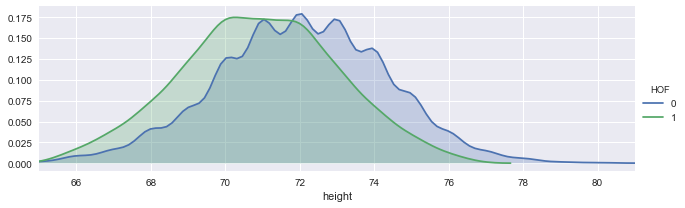

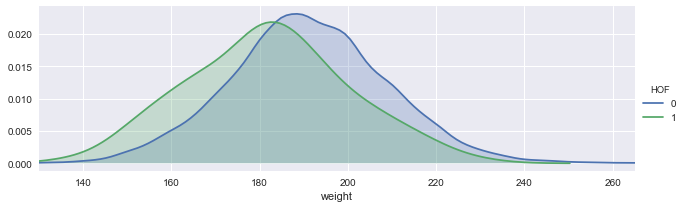

In [103]:
features_to_plot = ['birthYear','LastYear','FirstYear','Career_Years','GP','award_count','height', 'weight']
for feature in features_to_plot:
    plot_distribution(hockey, feature, 'HOF');

# 'series_wins','won_cup'